In [1]:
# comm = MPI.COMM_WORLD
rank = 0 # MPI.Comm_rank(comm)
root = 0
commsize = 4 # MPI.Comm_size(comm)

4

In [275]:
include("mode_init/MPAS_OceanHalos.jl")

moveArrays! (generic function with 2 methods)

In [276]:
println("loading ocean from file")

fullOcean = MPAS_Ocean("MPAS_O_Shallow_Water/Mesh+Initial_Condition+Registry_Files/Periodic", "base_mesh.nc", "mesh.nc", periodicity="Periodic")
"ocean loaded"

loading ocean from file


"ocean loaded"

In [277]:
println("dividing ocean")

halowidth = 4

cellsInChunk, edgesInChunk, verticesInChunk, cellsFromChunk, cellsToChunk = divide_ocean(fullOcean, halowidth, 2, 2)#; iChunk = rank+1)

myCells = cellsInChunk[rank+1] # cellsedgesvertices[1]
myEdges = edgesInChunk[rank+1] # cellsedgesvertices[2]
myVertices = verticesInChunk[rank+1] # cellsedgesvertices[3]

myOcean = mpas_subset(fullOcean, myCells, myEdges, myVertices)
"subset made"

dividing ocean


"subset made"

In [278]:
# MPI.Barrier(comm)

# println("ocean distributed between ranks.")

############### Ocean is now distributed between nodes. Let's do some simulation ####################

In [279]:
include("mode_init/initial_conditions.jl")

planeWaveInit! (generic function with 1 method)

In [280]:
# set up initial condition

gaussianInit!(myOcean)

gaussianInit!(fullOcean)

# MPI.Barrier(comm)

println("initial condition set.")

initial condition set.


In [281]:
include("visualization.jl")

vertexHeatMapMesh (generic function with 1 method)

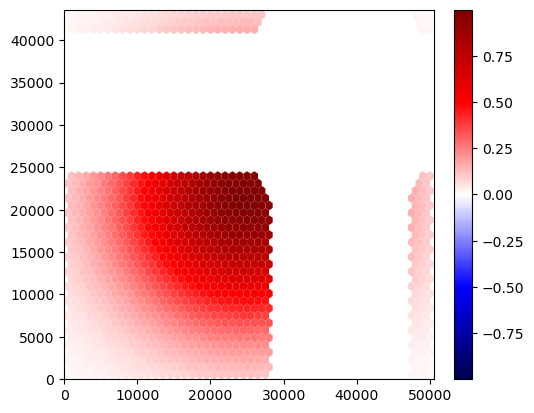

In [282]:
fig, ax, _ = heatMapMesh(myOcean, myOcean.sshCurrent)

display(fig)

In [283]:
# # show which chunk each piece of the halo came from
# for (srcchunk, localcells) in cellsFromChunk[1]
#     if srcchunk != 1
#         myOcean.sshCurrent[localcells] .= -srcchunk
#     end
# end

In [284]:
include("mode_forward/time_steppers.jl")

forward_euler_step_cuda! (generic function with 1 method)

In [285]:
update_halos = true

true

In [286]:
nFrames = 100

sshOverTime = zeros(nFrames, myOcean.nCells)
sshOverTimeFull = zeros(nFrames, fullOcean.nCells)

for f in 1:nFrames
    for i in 1:halowidth
        forward_backward_step!(myOcean)
        forward_backward_step!(fullOcean) # control
    end
    
    if update_halos
        for (srcchunk, localcells) in cellsFromChunk[rank+1]
            if srcchunk != rank+1
                myOcean.sshCurrent[localcells] = fullOcean.sshCurrent[myCells[localcells]]
                localedges = collect(Set(myOcean.edgesOnCell[:,localcells]))
                myOcean.normalVelocityCurrent[localedges] = fullOcean.normalVelocityCurrent[myEdges[localedges]]
            end
        end
    end
    
    
    sshOverTime[f,:] = myOcean.sshCurrent
    sshOverTimeFull[f,:] = fullOcean.sshCurrent
    
end

In [287]:
animation = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")

PyObject <module 'IPython.display' from '/home/rrs/anaconda3/envs/MPAS_Ocean/lib/python3.8/site-packages/IPython/display.py'>

In [288]:
fig = figure()

cMax = maximum(abs.(sshOverTime))

_, ax, _, collection = heatMapMesh(myOcean, sshOverTime[1,:], fig=fig, cMin=-cMax, cMax=cMax)

function nextFrame(j)
    i = j + 1
    
    collection.set_array(sshOverTime[i,:])
    
    return ax
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f98103aa580>

In [289]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [177]:
fig = figure()

cMax = maximum(abs.(sshOverTimeFull))

_, ax, _, collection = heatMapMesh(fullOcean, sshOverTimeFull[1,:], fig=fig, cMin=-cMax, cMax=cMax)

function nextFrame(j)
    i = j + 1
    
    collection.set_array(sshOverTimeFull[i,:])
    
    return ax
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f9810a7d040>

In [178]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>